In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
from functools import partial

# from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple
# from timm.models.registry import register_model
from einops import rearrange
import numpy as np

from torch.nn.attention.flex_attention import (create_block_mask, 
                                               flex_attention
)

torch.set_float32_matmul_precision('high')

# flex_attention = torch.com

# flex_attention = torch.compile(flex_attention, dynamic=False)
# from torch.nn.attention.flex_attention import flex_attention

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        # 'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'cswin_224': _cfg(),
    'cswin_384': _cfg(
        crop_pct=1.0
    ),

}


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class LePEAttention(nn.Module):
    def __init__(self, dim, resolution, idx, split_size=7, dim_out=None, num_heads=8, attn_drop=0., proj_drop=0., qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print ("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp
        stride = 1
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp* self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.H_sp, self.W_sp
        x = x.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp) ### B', C, H', W'
        lepe = func(x) ### B', C, H', W'
        lepe = lepe.reshape(-1, self.num_heads, C // self.num_heads, H_sp * W_sp).permute(0, 1, 3, 2).contiguous()

        x = x.reshape(-1, self.num_heads, C // self.num_heads, self.H_sp* self.W_sp).permute(0, 1, 3, 2).contiguous()
        return x, lepe

    def forward(self, qkv):
        """
        x: B L C
        """
        q,k,v = qkv[0], qkv[1], qkv[2]

        ### Img2Window
        H = W = self.resolution
        B, L, C = q.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        
        q = self.im2cswin(q)
        k = self.im2cswin(k)
        v, lepe = self.get_lepe(v, self.get_v)

        x = F.scaled_dot_product_attention(q, k, v) + lepe
        # q = q * self.scale
        # attn = (q @ k.transpose(-2, -1))  # B head N C @ B head C N --> B head N N
        # attn = nn.functional.softmax(attn, dim=-1, dtype=attn.dtype)
        # attn = self.attn_drop(attn)
        # print out shapes of major tensors
        # x = (attn @ v) + lepe
        x = x.transpose(1, 2).reshape(-1, self.H_sp* self.W_sp, C)  # B head N N @ B head N C

        ### Window2Img
        x = windows2img(x, self.H_sp, self.W_sp, H, W).view(B, -1, C)  # B H' W' C

        return x
    
def build_cswin_op(H, H_sp, W, W_sp, D=1, D_sp=1):
    ## Building this assuming 3D is a possibility
    ## Almost certainly a more efficient approach here, but don't want to spend forever
    def block_mask(b, h, q_idx, kv_idx):
        # Get x, y, z coordinates for q_idx and kv_idx, assuming stride is H, W, D
        z_q, z_kv = q_idx % D, kv_idx % D
        next_q, next_kv = q_idx // D, kv_idx // D
        x_q, x_kv = next_q % W, next_kv % W
        y_q, y_kv = next_q // W, next_kv // W
        # Now make sure each coord is in same window
        z_block_mask = (z_q // D_sp) == (z_kv // D_sp)
        x_block_mask = (x_q // W_sp) == (x_kv // W_sp)
        y_block_mask = (y_q // H_sp) == (y_kv // H_sp)
        return z_block_mask & x_block_mask  & y_block_mask
    return block_mask
    
class LePEAttentionFlex(nn.Module):
    def __init__(self, dim, resolution, idx, split_size=7, dim_out=None, num_heads=8, attn_drop=0., proj_drop=0., qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print ("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp
        self.block_mask_func = create_block_mask(build_cswin_op(self.resolution, self.H_sp, self.resolution, self.W_sp, 
                                                                1, 1), # Trailing 1s placeholder for 3D
                                                 B=None, H=None, Q_LEN=resolution**2,  KV_LEN=resolution**2,
                                                 # Block size is tricky - need to work through math to get better answer
                                                 # For 2D, we know that we have one direction contiguous and the other at stride
                                                 # "Resolution", so block size needs to be at least < resolution to get any 
                                                 # sparsity in that direction. But larger blocks translate to better 
                                                 # performance. So we'll start with resolution//4, but this is probably
                                                 # too small.
                                                #  BLOCK_SIZE=resolution, # Not working on nightly currently - fix later
                                                 _compile=True
                                                 ) # The 1 is because this is a 2D mask
        stride = 1
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp* self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        # x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.H_sp, self.W_sp
        x = rearrange(x, 'B (H Hsp W Wsp) C -> (B H W) C Hsp Wsp', Hsp=H_sp, Wsp=W_sp, H=H//H_sp)
        lepe = func(x) ### B', C, H', W'
        lepe = rearrange(lepe,'(B H W) C Hsp Wsp -> B (H Hsp W Wsp) C', B=B, H=H//H_sp)
        return lepe

    def forward(self, qkv):
        """
        x: B L C
        """
        q,k,v = qkv[0], qkv[1], qkv[2]

        ### Img2Window
        H = W = self.resolution
        B, L, C = q.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        
        lepe = self.get_lepe(v, self.get_v)

        # Print shapes of all major tensors
        q, k, v, lepe = map(lambda t: rearrange(t, 'B H (he C) -> B he H C', he=self.num_heads).contiguous(), (q, k, v, lepe))
        x = flex_attention(q, k, v, block_mask=self.block_mask_func) + lepe
        x = rearrange(x, 'B he H C -> B H (he C)')
        return x

class CSWinBlockFlex(nn.Module):
    def __init__(self, dim, reso, num_heads,
                 split_size=7, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)
        
        if last_stage:
            self.attns = nn.ModuleList([
                LePEAttentionFlex(
                    dim, resolution=self.patches_resolution, idx = -1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])
        else:
            self.attns = nn.ModuleList([
                LePEAttentionFlex(
                    dim//2, resolution=self.patches_resolution, idx = i,
                    split_size=split_size, num_heads=num_heads//2, dim_out=dim//2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])
        

        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """

        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)
        
        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:,:,:,:C//2])
            x2 = self.attns[1](qkv[:,:,:,C//2:])
            attened_x = torch.cat([x1,x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

class CSWinBlock(nn.Module):

    def __init__(self, dim, reso, num_heads,
                 split_size=7, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)
        
        if last_stage:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim, resolution=self.patches_resolution, idx = -1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])
        else:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim//2, resolution=self.patches_resolution, idx = i,
                    split_size=split_size, num_heads=num_heads//2, dim_out=dim//2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])
        

        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """

        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)
        
        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:,:,:,:C//2])
            x2 = self.attns[1](qkv[:,:,:,C//2:])
            attened_x = torch.cat([x1,x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

def img2windows(img, H_sp, W_sp):
    """
    img: B C H W
    """
    B, C, H, W = img.shape
    img_reshape = img.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
    img_perm = img_reshape.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(-1, H_sp* W_sp, C)
    return img_perm

def windows2img(img_splits_hw, H_sp, W_sp, H, W):
    """
    img_splits_hw: B' H W C
    """
    B = int(img_splits_hw.shape[0] / (H * W / H_sp / W_sp))

    img = img_splits_hw.view(B, H // H_sp, W // W_sp, H_sp, W_sp, -1)
    img = img.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return img

class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)
        
        return x

def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

/mnt/home/mmccabe/venvs/well_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
res = 256
torch.manual_seed(0)
m = torch.compile(CSWinBlockFlex(768, res, 12, 8).cuda(), dynamic=False, mode="max-autotune-no-cudagraphs")
torch.manual_seed(0)
m2 = torch.compile(CSWinBlock(768, res, 12, 8).cuda(), dynamic=False, mode="max-autotune-no-cudagraphs")
# mc = torch.compile(m)

x = torch.randn(1, res**2, 768).cuda()
m(x) - m2(x)


E0826 18:49:06.853000 1520393 torch/_inductor/select_algorithm.py:1300] [1/0_1] Exception out of resource: shared memory, Required: 262144, Hardware limit: 101376. Reducing block sizes or `num_stages` may help. for benchmark choice TritonTemplateCaller(/tmp/torchinductor_mmccabe/s7/cs7nyhfqv4kzrcqg7rf7ktr2h6bdjx37y552xl4vqmavokp7mc6w.py, ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=128, BLOCK_M=64, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=5, num_warps=4)
E0826 18:49:06.866000 1520393 torch/_inductor/select_algorithm.py:1300] [1/0_1] Exception out of resource: shared memory, Required: 196608, Hardware limit: 101376. Reducing block sizes or `num_stages` may help. for benchmark choice TritonTemplateCaller(/tmp/torchinductor_mmccabe/6y/c6yl5mjb2oalrpsah3z6o74gwqd76owob3jmzasoiqpji4omzzg6.py, ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=128, BLOCK_M=64, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=5, num_warps=4)
E0826 18:4

tensor([[[-1.3196e-04, -4.1336e-05, -8.9407e-05,  ..., -2.5988e-05,
           2.2542e-04,  1.3888e-05],
         [-3.1590e-06,  2.7418e-05, -1.4663e-05,  ..., -3.3379e-06,
           7.8082e-05, -1.9848e-05],
         [-9.5963e-05,  1.0452e-04, -5.5134e-06,  ..., -1.1876e-05,
          -5.0664e-06,  1.7166e-05],
         ...,
         [ 2.7031e-05,  9.2626e-05,  8.0585e-05,  ..., -5.5075e-05,
          -6.2168e-05,  4.1842e-05],
         [-2.5988e-05,  4.2677e-05, -5.3279e-05,  ...,  7.5996e-06,
           1.5914e-05, -6.3479e-05],
         [-1.8358e-05, -6.7115e-05,  1.5050e-05,  ..., -8.2254e-05,
           4.7386e-05, -1.6004e-05]]], device='cuda:0', grad_fn=<SubBackward0>)

In [4]:
torch.cuda.reset_peak_memory_stats()
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        m(x)
        m(x)
        m(x)
        m(x)
        mem = torch.cuda.max_memory_allocated() / 1024**3

print('Max mem', mem, 'GB')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

Max mem 11.330207824707031 GB
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  Torch-Compiled Region         0.65%       3.119ms         9.03%      42.994ms     977.127us       0.000us         0.00%        1.422s      32.313ms           0 b           

In [5]:
torch.cuda.reset_peak_memory_stats()
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        m2(x)
        m2(x)
        m2(x)
        m2(x)
        mem = torch.cuda.max_memory_allocated() / 1024**3

print('Max mem', mem, 'GB')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

Max mem 11.517707824707031 GB
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  Torch-Compiled Region         1.78%       4.909ms        23.45%      64.547ms     701.603us       0.000us         0.00%        1.248s      13.563ms         704 b           

In [24]:
%time m(x)

CPU times: user 11.9 ms, sys: 2.93 ms, total: 14.9 ms
Wall time: 13.5 ms


tensor([[[-0.9490,  0.4259,  2.0703,  ..., -2.0693,  0.1600, -0.6366],
         [ 0.2641, -1.0232, -1.1603,  ...,  1.3648,  0.6310, -0.6931],
         [-1.2044, -0.4342, -0.1973,  ...,  0.2379,  0.1587,  1.2159],
         ...,
         [-0.3595,  0.6229,  0.8600,  ...,  0.9993,  0.4613, -1.5493],
         [ 0.9457, -1.5176, -0.1061,  ...,  0.4901, -0.8905, -0.6047],
         [-1.3625, -1.8760, -0.1431,  ...,  1.8538,  0.9562, -0.4032]]],
       device='cuda:0', grad_fn=<CompiledFunctionBackward>)

In [25]:
%time m2(x)

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 47.50 GiB of which 82.50 MiB is free. Including non-PyTorch memory, this process has 47.06 GiB memory in use. Of the allocated memory 46.09 GiB is allocated by PyTorch, and 667.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## SWIN



In [2]:

import os
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

import torch
import torch.nn as nn

# from timm.models.registry import register_model

from rotary_embedding_torch import RotaryEmbedding, apply_rotary_emb
from torch.profiler import profile, record_function, ProfilerActivity

from functools import lru_cache


flex_attention = torch.compile(flex_attention, dynamic=False)

def build_space_block(params):
    #input_resolution = (
    #    params.img_size[0] // params.patch_size[0],
    #    params.img_size[1] // params.patch_size[0],
    #)

    if params.space_type == "swin":

        return partial(
            SwinTransformerBlock,
            dim=params.embed_dim,
            num_heads=params.num_heads,
            #input_resolution=input_resolution,
            window_size=params.window_size,
        )
    else:
        raise NotImplementedError



class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        return self.drop(self.fc2(x))


def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    #return x.permute(0, 1, 3, 2, 4, 5).reshape(-1, window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_partition_flex(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    #return x.permute(0, 1, 3, 2, 4, 5).reshape(-1, window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, -1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    B = windows.shape[0] // (H * W // window_size // window_size)
    x = windows.view(
        B, H // window_size, W // window_size, window_size, window_size, -1
    )
    #return x.permute(0, 1, 3, 2, 4, 5).reshape(B, H, W, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

def window_reverse_flex(windows, window_size, H, W):
    
    B = windows.shape[0] #// (H * W // window_size // window_size)
    x = windows.view(
        B, H // window_size, W // window_size, window_size, window_size, -1
    )
    #return x.permute(0, 1, 3, 2, 4, 5).reshape(B, H, W, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        pretrained_window_size (tuple[int]): The height and width of the window in pre-training.
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        attn_drop=0.0,
        proj_drop=0.0,
        pretrained_window_size=[0, 0],
    ):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.pretrained_window_size = pretrained_window_size
        self.num_heads = num_heads

        self.logit_scale = nn.Parameter(
            torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True
        )

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(
            nn.Linear(2, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_heads, bias=False),
        )

        # get relative_coords_table
        relative_coords_h = torch.arange(
            -(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32
        )
        relative_coords_w = torch.arange(
            -(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32
        )
        relative_coords_table = (
            torch.stack(torch.meshgrid([relative_coords_h, relative_coords_w]))
            .permute(1, 2, 0)
            .contiguous()
            .unsqueeze(0)
        )  # 1, 2*Wh-1, 2*Ww-1, 2
        if pretrained_window_size[0] > 0:
            relative_coords_table[:, :, :, 0] /= pretrained_window_size[0] - 1
            relative_coords_table[:, :, :, 1] /= pretrained_window_size[1] - 1
        else:
            relative_coords_table[:, :, :, 0] /= self.window_size[0] - 1
            relative_coords_table[:, :, :, 1] /= self.window_size[1] - 1
        relative_coords_table *= 8  # normalize to -8, 8
        relative_coords_table = (
            torch.sign(relative_coords_table)
            * torch.log2(torch.abs(relative_coords_table) + 1.0)
            / np.log2(8)
        )

        self.register_buffer("relative_coords_table", relative_coords_table)
        # print("RPE init", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(dim))
            self.v_bias = nn.Parameter(torch.zeros(dim))
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat(
                (
                    self.q_bias,
                    torch.zeros_like(self.v_bias, requires_grad=False),
                    self.v_bias,
                )
            )
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # cosine attention
        attn = F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1)
        # logit_scale = torch.clamp(self.logit_scale, max=torch.log(torch.tensor(1. / 0.01))).exp()
        max_value = torch.log(torch.tensor(1.0 / 0.01, device=self.logit_scale.device))
        logit_scale = torch.clamp(self.logit_scale, max=max_value).exp()
        attn = attn * logit_scale

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table)
        # print(relative_position_bias_table.shape)
        relative_position_bias_table = relative_position_bias_table.view(
            -1, self.num_heads
        )
        # print("INITIAL RPE", self.relative_coords_table.shape, relative_position_bias_table.shape, self.relative_position_index.shape)
        relative_position_bias = relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(
            self.window_size[0] * self.window_size[1],
            self.window_size[0] * self.window_size[1],
            -1,
        )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()  # nH, Wh*Ww, Wh*Ww
        # print("FINAL RPE", relative_position_bias.shape, attn.shape)
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(
                1
            ).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    r"""Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        input_resolution (tuple[int]): Input resulotion.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        pretrained_window_size (int): Window size in pre-training.
    """

    def __init__(
        self,
        dim,
        num_heads,
        #input_resolution=224,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.0,
        qkv_bias=True,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        pretrained_window_size=0,
    ):
        super().__init__()
        self.dim = dim
        #self.input_resolution = to_2tuple(input_resolution)
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
            pretrained_window_size=to_2tuple(pretrained_window_size),
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def create_attn_mask(self, H, W, window_size, shift_size, bcs, device):

        img_mask = torch.zeros((1, H, W, 1), device=device)  # 1 H W 1

        if shift_size > 0:
            h_slices = (
                slice(0, -window_size),
                slice(-window_size, -shift_size),
                slice(-shift_size, None),
            )
            w_slices = (
                slice(0, -window_size),
                slice(-window_size, -shift_size),
                slice(-shift_size, None),
            )
            cnt = 0
            if (bcs[0, 0] == 0) and (bcs[0, 1] == 0):
                for h in h_slices:
                    for w in w_slices:
                        img_mask[:, h, w, :] = cnt
                        cnt += 1
            elif (bcs[0, 0] == 1) and (bcs[0, 1] == 0):
                for w in w_slices:
                    img_mask[:, :, w, :] = cnt
                    cnt += 1
            elif (bcs[0, 0] == 0) and (bcs[0, 1] == 1):
                for h in h_slices:
                    img_mask[:, h, :, :] = cnt
                    cnt += 1
            else:
                pass

            mask_windows = window_partition(
                img_mask, window_size
            )  # nW, window_size, window_size, 1
            mask_windows = mask_windows.reshape(-1, window_size * window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(
                attn_mask != 0, float(-100.0)
            ).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        return attn_mask

    def forward(self, x, bcs, resolution):

        #H, W = self.input_resolution
        H, W = resolution
        B, L, C = x.shape

        assert L == H * W, "input feature has wrong size"
        device = x.device
        attn_mask = self.create_attn_mask(
            H, W, self.window_size, self.shift_size, bcs, device
        )

        shortcut = x
        # x = rearrange(x, 'b (h w) c -> b h w c', h=H)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(
            shifted_x, self.window_size
        )  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(
            -1, self.window_size * self.window_size, C
        )  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(
            x_windows, mask=attn_mask
        )  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x

        # x = rearrange(x, 'b h w c -> b (h w) c')
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(self.norm1(x))

        # FFN
        x = x + self.drop_path(self.norm2(self.mlp(x)))

        return x
    
# def build_swin_mask_and_window_block()
LN_100 = np.log(100)

# def create_swin_score_mod(H, W):
#     def swin_score_mod(score, b, h, q_idx, kv_idx):
#         qx, qy = q_idx % W, q_idx // W
#         kvx, kvy = kv_idx % W, kv_idx // W
#         # scale = torch.clamp(logit_scale[h], max=LN_100).exp()
#         return score + 16 * torch.sigmoid(relative_position_scores[kvy-qy + H//2, kvx-qx+W//2, h])
#     return swin_score_mod

@lru_cache
def create_block_mask_cached(score_mod, B, H, M, N, device="cuda"):
    block_mask = create_block_mask(score_mod, B, H, M, N, device=device)
    return block_mask


def create_swindow_mask(H, W, window_size, shift_size, bcs, device="cuda"):
    # @lru_cache()
    def swindow_mask(b, h, q_idx, kv_idx):
        mask_size = window_size**2

        q_window = q_idx // mask_size
        kv_window = kv_idx // mask_size
        # return q_window == kv_window
        qlocal_idx = q_idx % mask_size
        kvlocal_idx = kv_idx % mask_size
        
        windows_per_row = W // window_size
        windows_per_col = H // window_size
        # Get 2D block coordinates
        q_block_x = q_window % windows_per_row
        q_block_y = q_window // windows_per_row
        kv_block_x = kv_window % windows_per_row
        kv_block_y = kv_window // windows_per_row
        # Now get the local coordinates within the block
        qx = q_block_x * window_size + qlocal_idx % window_size
        qy = q_block_y * window_size + qlocal_idx // window_size
        kvx = kv_block_x * window_size + kvlocal_idx % window_size
        kvy = kv_block_y * window_size + kvlocal_idx // window_size

        # print(q_idx, 'block_id:', q_window, ', block x:', q_block_x, ', x:', qx, ', block y:', q_block_y, ', y:', qy)
        # qx, qy = q_idx % W, q_idx // W
        # kvx, kvy = kv_idx % W, kv_idx // W
        x_mask = qx // window_size == kvx // window_size
        y_mask = qy // window_size == kvy // window_size
        # mask = q_idx // mask_size == kv_idx // mask_size
        if shift_size > 0:
            if bcs[0, 0] == 0:
                y_mask &= kvx < H - shift_size
                y_mask &= qx < H - shift_size
            elif bcs[0, 1] == 0:
                x_mask &= kvx < W - shift_size
                y_mask &= qx < H - shift_size
        return x_mask & y_mask
    return swindow_mask

class WindowAttentionFlex(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        pretrained_window_size (tuple[int]): The height and width of the window in pre-training.
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        attn_drop=0.0,
        proj_drop=0.0,
        pretrained_window_size=[0, 0],
    ):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.pretrained_window_size = pretrained_window_size
        self.num_heads = num_heads

        self.logit_scale = nn.Parameter(
            torch.log(10 * torch.ones((num_heads, 1, 1, 1))), requires_grad=True
        )
        # swindow_mask = create_swindow_mask(64, 64, 8, 0, torch.tensor([0, 0]))
        # self.swin_mask = create_block_mask(swindow_mask, None, None, 256**2, 256**2, BLOCK_SIZE = 256,
        #                                    device="cuda")
        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(
            nn.Linear(2, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_heads, bias=False),
        )
        # get relative_coords_table
        # relative_coords_h = torch.arange(
        #     -(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32
        # )
        # relative_coords_w = torch.arange(
        #     -(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32
        # )
        # relative_coords_table = (
        #     torch.stack(torch.meshgrid([relative_coords_h, relative_coords_w]))
        #     .permute(1, 2, 0)
        #     .contiguous()
        #     .unsqueeze(0)
        # )  # 1, 2*Wh-1, 2*Ww-1, 2
        # if pretrained_window_size[0] > 0:
        #     relative_coords_table[:, :, :, 0] /= pretrained_window_size[0] - 1
        #     relative_coords_table[:, :, :, 1] /= pretrained_window_size[1] - 1
        # else:
        #     relative_coords_table[:, :, :, 0] /= self.window_size[0] - 1
        #     relative_coords_table[:, :, :, 1] /= self.window_size[1] - 1
        # relative_coords_table *= 8  # normalize to -8, 8
        # relative_coords_table = (
        #     torch.sign(relative_coords_table)
        #     * torch.log2(torch.abs(relative_coords_table) + 1.0)
        #     / np.log2(8)
        # )

        # self.register_buffer("relative_coords_table", relative_coords_table)

        # # get pair-wise relative position index for each token inside the window
        # coords_h = torch.arange(self.window_size[0])
        # coords_w = torch.arange(self.window_size[1])
        # coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        # coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        # relative_coords = (
        #     coords_flatten[:, :, None] - coords_flatten[:, None, :]
        # )  # 2, Wh*Ww, Wh*Ww
        # relative_coords = relative_coords.permute(
        #     1, 2, 0
        # ).contiguous()  # Wh*Ww, Wh*Ww, 2
        # relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        # relative_coords[:, :, 1] += self.window_size[1] - 1
        # relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        # self.register_buffer("relative_position_index", relative_position_index)
        self.rope = RotaryEmbedding(dim // (num_heads * len(self.window_size)))
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(dim))
            self.v_bias = nn.Parameter(torch.zeros(dim))
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        # print("starting flex", x.shape)
        B_, Nw, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat(
                (
                    self.q_bias,
                    torch.zeros_like(self.v_bias, requires_grad=False),
                    self.v_bias,
                )
            )
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B_, Nw, N, 3, self.num_heads, -1).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]


        # cosine attention
        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1)
        q = torch.clamp(self.logit_scale, LN_100).exp() * q
        
        freqs = self.rope.get_axial_freqs(*self.window_size)

        q =  q.view(B_, self.num_heads, Nw, *self.window_size, -1)
        k = k.view(B_, self.num_heads, Nw, *self.window_size, -1)
        q, k = apply_rotary_emb(freqs, q), apply_rotary_emb(freqs, k)
        q, k = q.view(B_, self.num_heads,  Nw*N, -1), k.view(B_, self.num_heads,  Nw*N, -1)
        v = v.view(B_, self.num_heads, Nw*N, -1)


        # attn = F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1)
        # logit_scale = torch.clamp(self.logit_scale, max=torch.log(torch.tensor(1. / 0.01))).exp()
        # max_value = torch.log(torch.tensor(1.0 / 0.01, device=self.logit_scale.device))
        # logit_scale = torch.clamp(self.logit_scale, max=max_value).exp()
        # attn = attn * logit_scale
        

        # relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).squeeze()
        # score_mod = create_swin_score_mod(relative_position_bias_table, self.logit_scale, self.window_size[0], self.window_size[1])
        
        #.view(
        #    -1, self.num_heads
        #)
        # print('RPE stats', relative_position_bias_table.shape, self.relative_coords_table.shape)
        # relative_position_bias = relative_position_bias_table[
        #     self.relative_position_index.view(-1)
        # ].view(
        #     self.window_size[0] * self.window_size[1],
        #     self.window_size[0] * self.window_size[1],
        #     -1,
        # )  # Wh*Ww,Wh*Ww,nH
        # relative_position_bias = relative_position_bias.permute(
        #     2, 0, 1
        # ).contiguous()  # nH, Wh*Ww, Wh*Ww
        # relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        # print("Final RPE", relative_position_bias.shape, attn.shape)
        # attn = attn + relative_position_bias.unsqueeze(0)

        # if mask is not None:
        #     nW = mask.shape[0]
        #     attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(
        #         1
        #     ).unsqueeze(0)
        #     attn = attn.view(-1, self.num_heads, N, N)
        #     attn = self.softmax(attn)
        # else:
        #     attn = self.softmax(attn)

        # attn = self.attn_drop(attn)
        # print shapes of all major tensors
        # print("q", q.shape, "k", k.shape, "v", v.shape)
        x = flex_attention(q, k, v, block_mask=mask).reshape(B_, Nw, N, C)
        # x = F.scaled_dot_product_attention(q, k, v).transpose(-1, -2).reshape(B_, Nw, N, C)

        # x = (attn @ v)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlockFlex(nn.Module):
    r"""Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        input_resolution (tuple[int]): Input resulotion.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        pretrained_window_size (int): Window size in pre-training.
    """

    def __init__(
        self,
        dim,
        num_heads,
        #input_resolution=224,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.0,
        qkv_bias=True,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        pretrained_window_size=0,
    ):
        super().__init__()
        self.dim = dim
        #self.input_resolution = to_2tuple(input_resolution)
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttentionFlex(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
            pretrained_window_size=to_2tuple(pretrained_window_size),
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def create_attn_mask(self, H, W, window_size, shift_size, bcs, device):

        img_mask = torch.zeros((1, H, W, 1), device=device)  # 1 H W 1

        if shift_size > 0:
            h_slices = (
                slice(0, -window_size),
                slice(-window_size, -shift_size),
                slice(-shift_size, None),
            )
            w_slices = (
                slice(0, -window_size),
                slice(-window_size, -shift_size),
                slice(-shift_size, None),
            )
            cnt = 0
            if (bcs[0, 0] == 0) and (bcs[0, 1] == 0):
                for h in h_slices:
                    for w in w_slices:
                        img_mask[:, h, w, :] = cnt
                        cnt += 1
            elif (bcs[0, 0] == 1) and (bcs[0, 1] == 0):
                for w in w_slices:
                    img_mask[:, :, w, :] = cnt
                    cnt += 1
            elif (bcs[0, 0] == 0) and (bcs[0, 1] == 1):
                for h in h_slices:
                    img_mask[:, h, :, :] = cnt
                    cnt += 1
            else:
                pass

            mask_windows = window_partition(
                img_mask, window_size
            )  # nW, window_size, window_size, 1
            mask_windows = mask_windows.reshape(-1, window_size * window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(
                attn_mask != 0, float(-100.0)
            ).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        return attn_mask

    def forward(self, x, bcs, resolution, mask=None):

        #H, W = self.input_resolution
        H, W = resolution
        B, L, C = x.shape

        assert L == H * W, "input feature has wrong size"
        device = x.device
        # attn_mask = self.create_attn_mask(
        #     H, W, self.window_size, self.shift_size, bcs, device
        # )
        # swin_mask = create_swindow_mask(H, W, self.window_size, self.shift_size, bcs, device)
        # swin_mask = create_block_mask(swin_mask, None, None, H*W, H*W, BLOCK_SIZE = self.window_size**2,
        #                      device=device)
        shortcut = x
        # x = rearrange(x, 'b (h w) c -> b h w c', h=H)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition_flex(
            shifted_x, self.window_size
        )  # B, nW, window_size, window_size, C
        x_windows = x_windows.view(
            B, -1, self.window_size * self.window_size, C
        )  # B, nW, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(
            x_windows, mask=mask
        )  # B, nW, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(B, -1, self.window_size, self.window_size, C)
        shifted_x = window_reverse_flex(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x

        # x = rearrange(x, 'b h w c -> b (h w) c')
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(self.norm1(x))

        # FFN
        x = x + self.drop_path(self.norm2(self.mlp(x)))

        return x

In [3]:
resolution = 64
window_size = 8
m = SwinTransformerBlockFlex(768, 12, window_size).cuda()
m2 = SwinTransformerBlock(768, 12, window_size).cuda()
x = torch.randn(1, resolution**2, 768).cuda()
BCs = torch.tensor([[0, 0]]).cuda()
swindow_mask = create_swindow_mask(resolution, resolution, window_size, 0, BCs, device="cuda")

mask = create_block_mask(swindow_mask, None, None, resolution**2, resolution**2, BLOCK_SIZE = window_size**2,
                                           device="cuda", _compile=True)


m(x, BCs, (resolution, resolution), mask).shape, m2(x, BCs, (resolution, resolution)).shape

# m(x, BCs, (resolution, resolution))

/mnt/home/mmccabe/venvs/well_venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


UserFunctionVariable()


(torch.Size([1, 4096, 768]), torch.Size([1, 4096, 768]))

In [4]:
print(mask)

BlockMask(shape=(1, 1, 8192, 8192), sparsity=98.44%, 
(0, 0)
░░                              
  ░░                            
    ░░                          
      ░░                        
        ░░                      
          ░░                    
            ░░                  
              ░░                
                ░░              
                  ░░            
                    ░░          
                      ░░        
                        ░░      
                          ░░    
                            ░░  
                              ░░
)


In [5]:
!export TORCHDYNAMO_VERBOSE=1

In [15]:
%time m(x, BCs, (resolution, resolution))

CPU times: user 11.1 ms, sys: 1.04 ms, total: 12.1 ms
Wall time: 11.2 ms


tensor([[[ 0.8911, -2.0237,  0.0874,  ...,  1.8481,  1.9463, -1.6693],
         [ 2.3655, -1.3664,  2.8995,  ...,  2.5285,  0.8015, -1.1482],
         [ 1.0134, -1.1104, -1.7366,  ..., -0.5531,  5.1501,  0.4722],
         ...,
         [ 2.4366, -0.6986,  0.0683,  ...,  1.6818,  1.6937, -2.3127],
         [ 1.4351,  2.2723,  1.6191,  ..., -1.1244,  2.6846, -1.7992],
         [ 2.8857,  1.1299, -0.7580,  ..., -1.2703,  1.9062, -0.0733]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [16]:
%%time 

m2(x, BCs, (resolution, resolution))

CPU times: user 9.78 ms, sys: 1.21 ms, total: 11 ms
Wall time: 10.1 ms


tensor([[[ 0.7518, -0.1979, -0.2501,  ...,  2.0128, -0.7517, -2.0941],
         [-0.0382,  1.1054, -0.1532,  ...,  0.9081, -1.3076, -0.3362],
         [ 0.4059,  2.5880, -1.6139,  ..., -1.6082,  0.2722,  0.8511],
         ...,
         [ 1.7862,  2.9913,  0.8791,  ...,  2.2209, -2.2367, -1.7994],
         [-1.8505,  3.8987, -0.4162,  ..., -0.6142, -1.0749, -2.2390],
         [-0.6067,  3.0438,  0.8687,  ..., -0.4416, -0.7304, -1.5081]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [18]:
x = torch.randn(1, resolution**2, 768).cuda()
torch.cuda.reset_peak_memory_stats()
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        x = m(x, BCs, (resolution, resolution), mask)
        x = m(x, BCs, (resolution, resolution), mask)
        x = m(x, BCs, (resolution, resolution), mask)
        y = m(x, BCs, (resolution, resolution), mask)
        z = y.sum()
        z.backward()
        mem = torch.cuda.max_memory_allocated() / 1024**3

print('Max mem', mem, 'GB')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
m.zero_grad()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
x = torch.randn(1, resolution**2, 768).cuda()
torch.cuda.reset_peak_memory_stats()
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        x = m2(x, BCs, (resolution, resolution))
        x = m2(x, BCs, (resolution, resolution))
        x = m2(x, BCs, (resolution, resolution))
        y = m2(x, BCs, (resolution, resolution))
        z = y.sum()
        z.backward()
        mem = torch.cuda.max_memory_allocated() / 1024**3

print('Max mem', mem, 'GB')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
m2.zero_grad()

AUTOTUNE mm(961x12, 12x512)
  triton_mm_973 0.0075 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_977 0.0075 ms 99.6% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=3, num_warps=8
  triton_mm_971 0.0075 ms 99.1% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=1, num_warps=2
  triton_mm_972 0.0076 ms 97.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=2, num_warps=4
  triton_mm_974 0.0078 ms 95.5% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_975 0.0078 ms 95.5% ACC_

Max mem 35.06066131591797 GB
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: CompiledFunctio...         0.00%     328.753us        49.33%       98.048s       24.512s       0.000us         0.00%       18.096s        4.524s           0 b           0

In [33]:
orig = 512
k = 200
extrap = k*orig


orig_logits = [10] + [0]*orig
new_logits = [10] + [0]*extrap

t = -orig_logits[0] / (np.log(k)-orig_logits[0])
print(t)

print(torch.softmax(torch.Tensor(orig_logits), dim=-1))
print(torch.softmax(torch.Tensor(new_logits)/.65, dim=-1))

2.126898129799549
tensor([9.7728e-01, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05, 4.4369e-05,
        4.4369e-05, 4.

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15]]) block_id: tensor([[0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3]]) , block x: tensor([[0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1]]) , x: tensor([[0],
        [1],
        [0],
        [1],
        [2],
        [3],
        [2],
        [3],
        [0],
        [1],
        [0],
        [1],
        [2],
        [3],
        [2],
        [3]]) , block y: tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
       

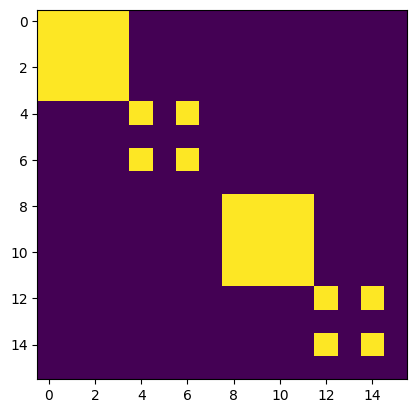

In [84]:
def create_swindow_mask(H, W, window_size, shift_size, bcs, device="cuda"):
    # @lru_cache()
    def swindow_mask(b, h, q_idx, kv_idx):
        mask_size = window_size**2

        q_window = q_idx // mask_size
        kv_window = kv_idx // mask_size
        # return q_window == kv_window
        qlocal_idx = q_idx % mask_size
        kvlocal_idx = kv_idx % mask_size
        
        windows_per_row = W // window_size
        windows_per_col = H // window_size
        # Get 2D block coordinates
        q_block_x = q_window % windows_per_row
        q_block_y = q_window // windows_per_row
        kv_block_x = kv_window % windows_per_row
        kv_block_y = kv_window // windows_per_row
        # Now get the local coordinates within the block
        qx = q_block_x * window_size + qlocal_idx % window_size
        qy = q_block_y * window_size + qlocal_idx // window_size
        kvx = kv_block_x * window_size + kvlocal_idx % window_size
        kvy = kv_block_y * window_size + kvlocal_idx // window_size

        # print(q_idx, 'block_id:', q_window, ', block x:', q_block_x, ', x:', qx, ', block y:', q_block_y, ', y:', qy)
        # qx, qy = q_idx % W, q_idx // W
        # kvx, kvy = kv_idx % W, kv_idx // W
        x_mask = qx // window_size == kvx // window_size
        y_mask = qy // window_size == kvy // window_size
        # mask = q_idx // mask_size == kv_idx // mask_size
        if shift_size > 0:
            if bcs[0, 0] == 0:
                y_mask &= kvx < H - shift_size
                y_mask &= qx < H - shift_size
            elif bcs[0, 1] == 0:
                x_mask &= kvx < W - shift_size
                y_mask &= qx < H - shift_size
        return x_mask & y_mask
    return swindow_mask

H = 4
W = 4
window_size = 2
shift_size = 1
bcs = torch.tensor([[0, 0]])
device = "cuda"
swindow_mask = create_swindow_mask(H, W, window_size, shift_size, bcs, device)
import matplotlib.pyplot as plt

mask = swindow_mask(None, None, torch.arange(H*W)[:, None], torch.arange(H*W)[None, :])

plt.imshow(mask)

In [80]:
for i in range(16):
    swindow_mask(None, None, i, i)

0 block_id: 0 , block x: 0 , x: 0 , block y: 0 , y: 0
1 block_id: 0 , block x: 0 , x: 1 , block y: 0 , y: 0
2 block_id: 0 , block x: 0 , x: 0 , block y: 0 , y: 1
3 block_id: 0 , block x: 0 , x: 1 , block y: 0 , y: 1
4 block_id: 1 , block x: 1 , x: 2 , block y: 0 , y: 0
5 block_id: 1 , block x: 1 , x: 3 , block y: 0 , y: 0
6 block_id: 1 , block x: 1 , x: 2 , block y: 0 , y: 1
7 block_id: 1 , block x: 1 , x: 3 , block y: 0 , y: 1
8 block_id: 2 , block x: 0 , x: 0 , block y: 1 , y: 2
9 block_id: 2 , block x: 0 , x: 1 , block y: 1 , y: 2
10 block_id: 2 , block x: 0 , x: 0 , block y: 1 , y: 3
11 block_id: 2 , block x: 0 , x: 1 , block y: 1 , y: 3
12 block_id: 3 , block x: 1 , x: 2 , block y: 1 , y: 2
13 block_id: 3 , block x: 1 , x: 3 , block y: 1 , y: 2
14 block_id: 3 , block x: 1 , x: 2 , block y: 1 , y: 3
15 block_id: 3 , block x: 1 , x: 3 , block y: 1 , y: 3
